In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re



import DataImport
import ProcessTrips

trips = ProcessTrips.transformTrips(DataImport.trips)
zones = DataImport.zones

Original number of rows: 4667
Number of rows after removing outliers: 4667
Number of rows after dropping NA values: 4667


### Dataset preparation. <br>
- Remove highly correlated columns
- Split dataset to test and train


In [2]:
# Select only numerical columns for correlation analysis ]
numerical_cols = trips.select_dtypes(include=[np.number]).columns

# Exclude the target variable 'total_amount' from the correlation analysis
numerical_cols = numerical_cols[numerical_cols != 'total_amount']

#Calculate the correlation matrix
corr_matrix = trips[numerical_cols].corr()

# Identify and mark features with correlation higher than the threshold (0.8)
correlated_features = set()
threshold = 0.75
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # Only consider the correlation if it's above the threshold
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Step 4: Print out the correlated features to drop
print(f"Correlated features (above {threshold}) to drop: {correlated_features}")

# Step 5: Drop the correlated features but keep 'total_amount'
trips = trips.drop(columns=correlated_features)

# Display remaining columns
print(f"Remaining features after dropping correlated ones: {trips.columns.tolist()}")


Correlated features (above 0.75) to drop: {'trip_duration', 'fare_amount'}
Remaining features after dropping correlated ones: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'file_date', 'eom_plus_1', 'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time', 'pickup_hour', 'PULocationID_encoded', 'DOLocationID_encoded', 'VendorID_encoded', 'RatecodeID_1', 'RatecodeID_99', 'pickup_weekday_Tuesday']


Split data to train and test 

In [3]:
rng = np.random.default_rng(123)

dt_index = trips.index
smpl_index = rng.choice(dt_index, size=int(np.floor(0.8 * len(dt_index))), replace=False)

dt_train = trips.loc[smpl_index].reset_index(drop=True)
dt_test = trips.drop(smpl_index)  # Drop selected indices to get the test set

print(len(dt_train))
print(len(dt_test))

3733
934


C:\Users\Eimante\AppData\Local\Temp\ipykernel_5132\4074762619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = scipy.stats.pearsonr(x, y)
C:\Users\Eimante\AppData\Local\Temp\ipykernel_5132\4074762619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = scipy.stats.pearsonr(x, y)
C:\Users\Eimante\AppData\Local\Temp\ipykernel_5132\4074762619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = scipy.stats.pearsonr(x, y)
C:\Users\Eimante\AppData\Local\Temp\ipykernel_5132\4074762619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = scipy.stats.pearsonr(x, y)
C:\Users\Eimante\AppData\Local\Temp\ipykernel_5132\4074762619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = scipy.stats.pearsonr(x, y)
C:\Users\E

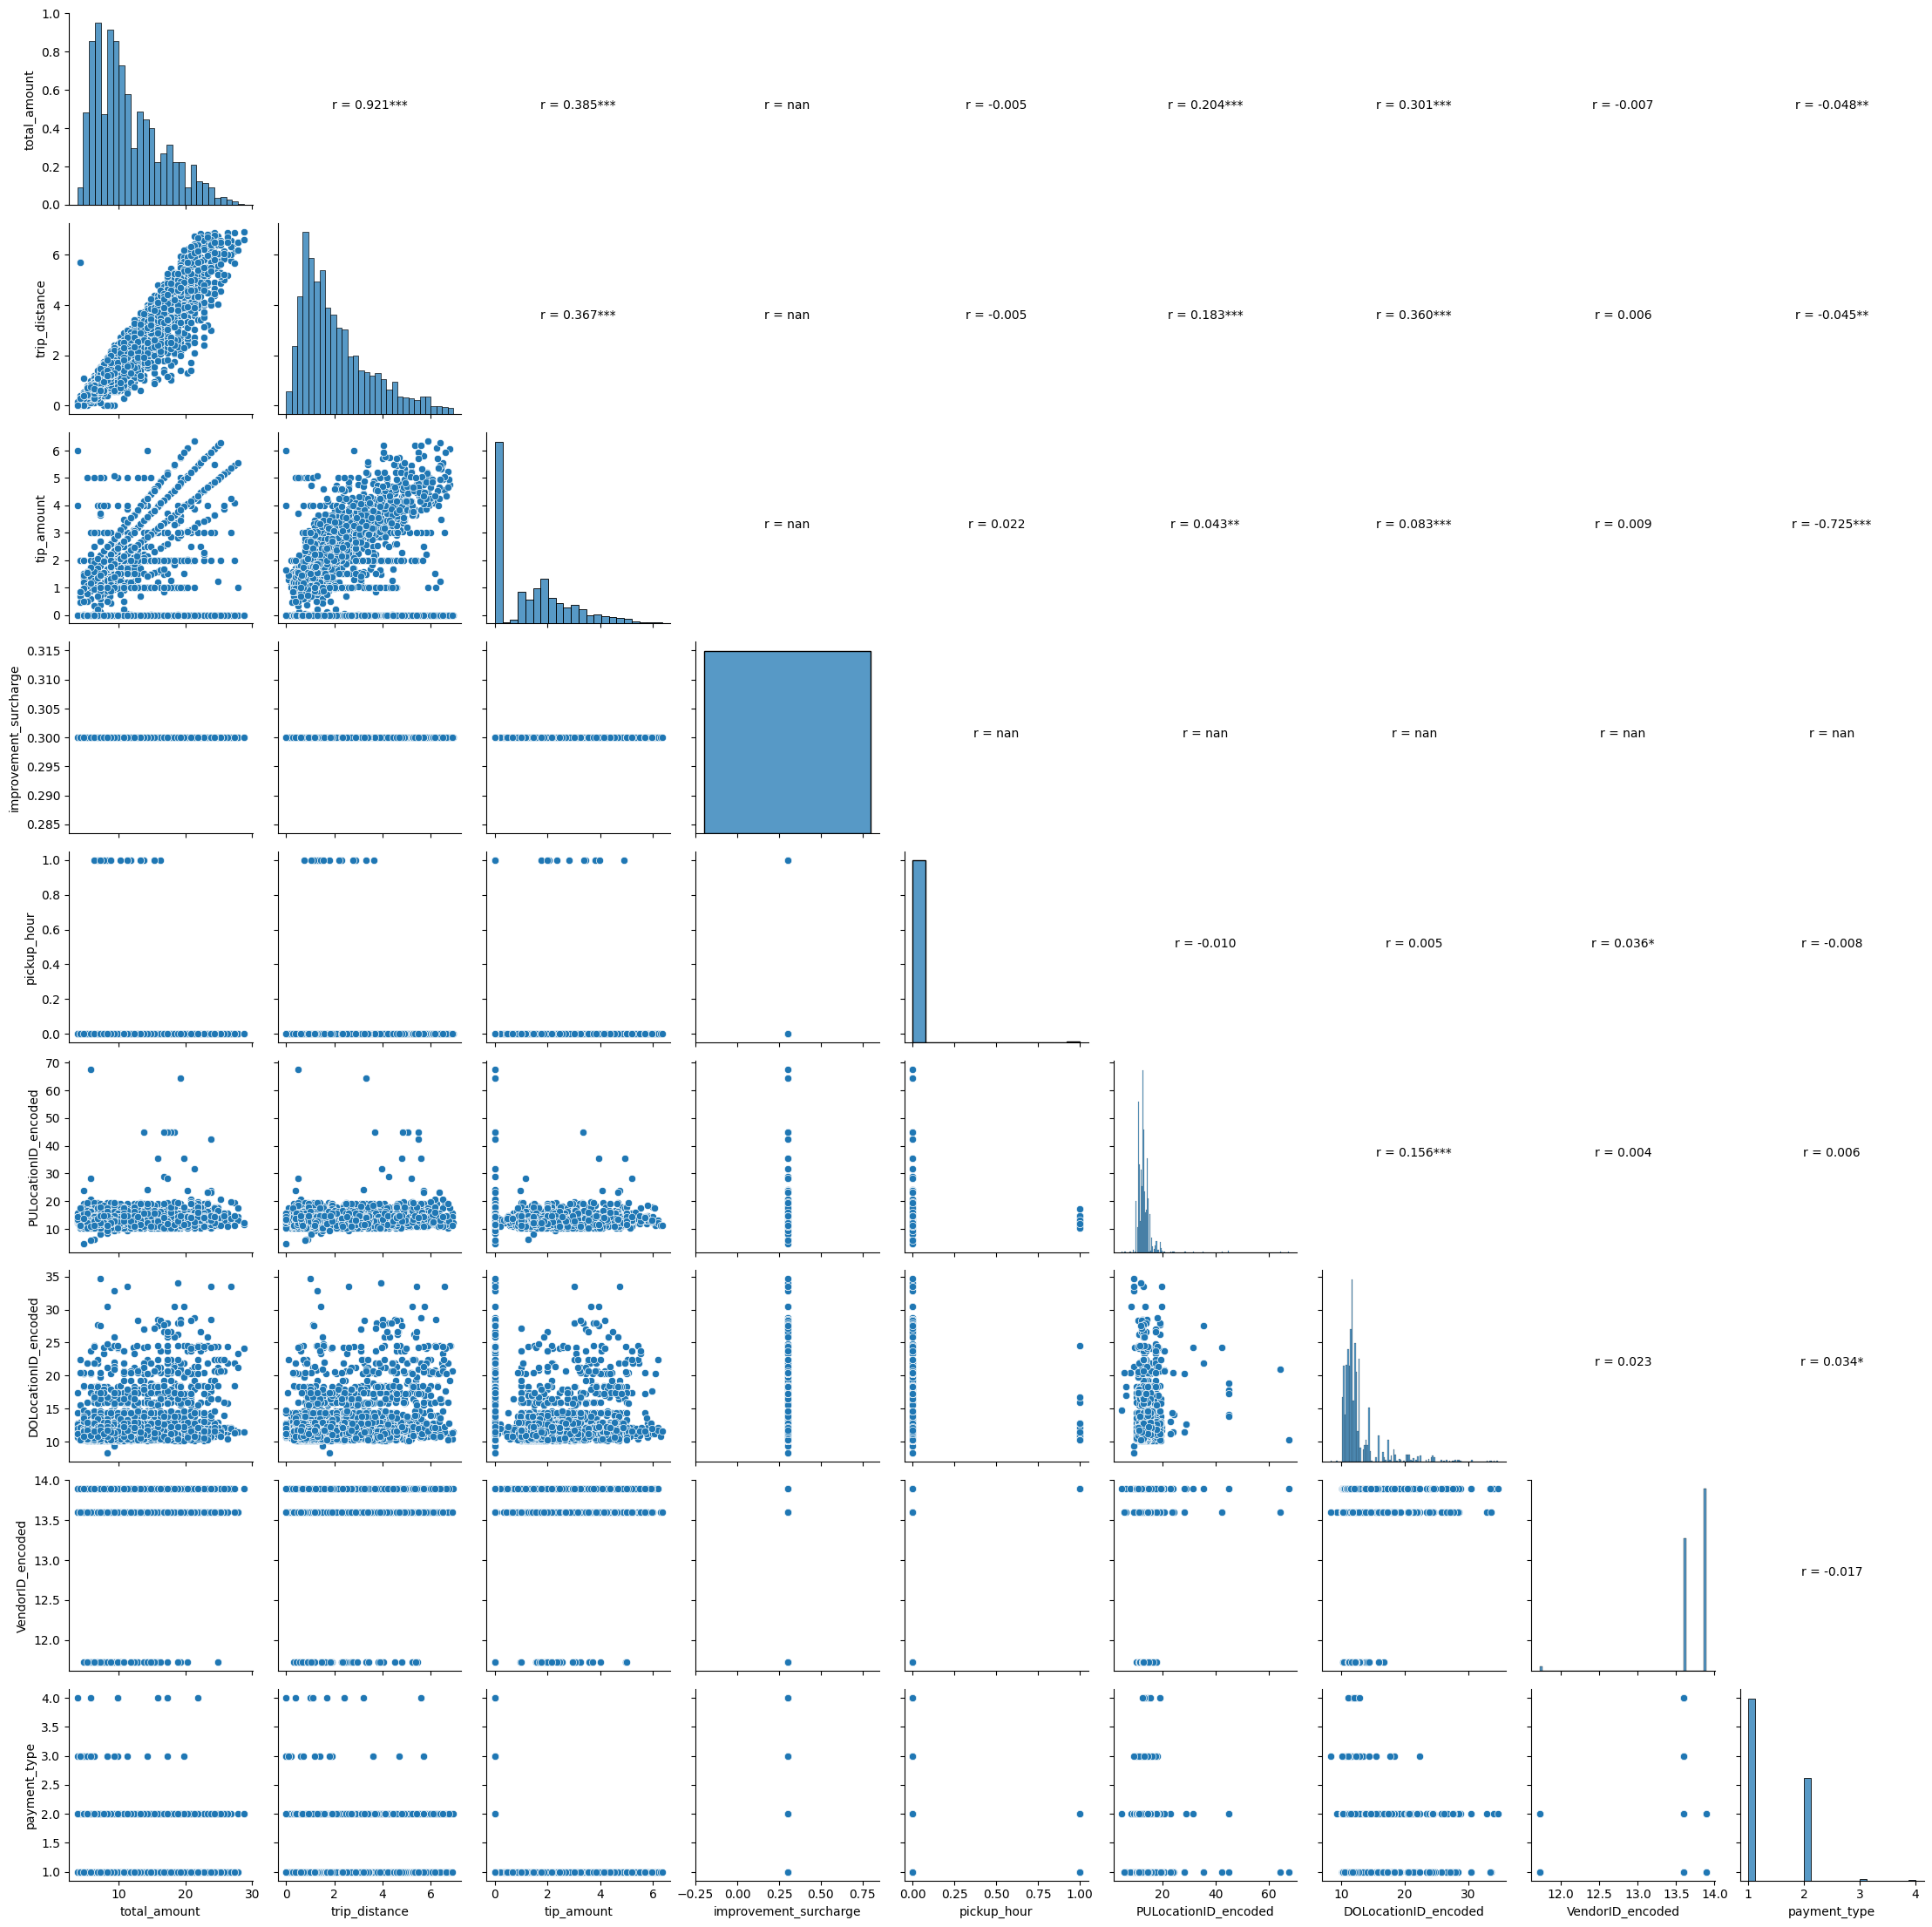

In [6]:
import scipy
# For plot size options, see: plotnine.options.figure_size = (., .)
import matplotlib.pyplot as plt
# plt.figure(figsize = (., .))
import seaborn as sns

# Specify the column names to plot
columns_to_plot = ['total_amount','trip_distance', 'tip_amount', 'improvement_surcharge', 'pickup_hour' ,  'PULocationID_encoded', 'DOLocationID_encoded', 'VendorID_encoded', 'payment_type']

#Note: before this I dropped NA values in dataset transformations.
def reg_coef(x, y, label=None, color=None, **kwargs):
    # A modified version of https://stackoverflow.com/a/63433499
    ax = plt.gca()
    r,p = scipy.stats.pearsonr(x, y)
    val = 'r = {:.3f}'.format(r)
    if p <= 0.001:
        val = val + "***"  
    elif p <= 0.01:
        val = val + "**"  
    elif p <= 0.05:
        val = val + "*"    
    ax.annotate(val, xy=(0.5, 0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
# g = sns.PairGrid(dt_train.iloc[:, [3,4,9,12,15,22,23]], diag_sharey = False)
g = sns.PairGrid(dt_train[columns_to_plot], diag_sharey=False)
tmp_plt = g.map_diag(sns.histplot)
tmp_plt = g.map_lower(sns.scatterplot)
tmp_plt = g.map_upper(reg_coef)
plt.show()

In [ ]:

import re


formula = """
np.log(total_amount) ~ 
    np.log(trip_distance + 1) +
    np.power(trip_distance, 2) +
    mta_tax +
    np.log(extra + 1) + 
    np.log(tip_amount + 1) + 
    np.log(tolls_amount + 1) +
    improvement_surcharge + 
    RatecodeID_1 + 
    np.log(passenger_count + 1) + 
    np.log(PULocationID_encoded + 1) + 
    np.log(DOLocationID_encoded + 1) + 
    np.log(VendorID + 1) +
    C(pickup_hour) +
    C(store_and_fwd_flag)
"""



# Iteratively remove variables with P > 0.05
while True:
    # Fit the model
    mdl = smf.ols(formula=formula, data=dt_train).fit()
    
    # Get the summary table
    summary_table = mdl.summary2().tables[1]
    
    # Identify variables with P > 0.05
    high_p_columns = summary_table[summary_table['P>|t|'] > 0.05].index.tolist()
    
    if not high_p_columns:
        # Stop the loop if no variables with P > 0.05 remain
        break
    
    # Remove the first variable with high p-value
    variable_to_remove = high_p_columns[0]
    
    # Regex to match the variable in the formula
    pattern = re.escape(variable_to_remove.split("[")[0])  # Handle categorical variables
    formula_rhs = formula.split("~")[1]  # Extract predictors (right-hand side)
    formula_rhs = re.sub(rf"\+?\s*{pattern}[^\+]*", "", formula_rhs)  # Remove the term
    
    # Clean up the formula (remove redundant "+" signs or spaces)
    formula_rhs = re.sub(r"\s*\+\s*", " + ", formula_rhs.strip()).strip(" +")
    formula = f"np.log(total_amount) ~ {formula_rhs}"  # Reconstruct the formula
    
    print(f"Removed: {variable_to_remove}")

# Print the final formula and summary
print("Final formula:", formula)
print(mdl.summary())


Removed: RatecodeID_1[T.True]
Removed: C(pickup_hour)[T.1]
Removed: C(store_and_fwd_flag)[T.Y]
Removed: np.log(DOLocationID_encoded + 1)
Final formula: np.log(total_amount) ~ np.log(trip_distance + 1) + np.power(trip_distance, 2) + mta_tax + np.log(extra + 1) + np.log(tip_amount + 1) + np.log(tolls_amount + 1) + improvement_surcharge + np.log(passenger_count + 1) + np.log(PULocationID_encoded + 1) + np.log(VendorID + 1)
                             OLS Regression Results                             
Dep. Variable:     np.log(total_amount)   R-squared:                       0.866
Model:                              OLS   Adj. R-squared:                  0.866
Method:                   Least Squares   F-statistic:                     4019.
Date:                  Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                          00:51:31   Log-Likelihood:                 1636.4
No. Observations:                  3733   AIC:                            -3259.
Df Residu

In [8]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Replace zeros with a small constant (e.g., 1e-5) to avoid invalid log transformations
dt_train["total_amount"] = dt_train["total_amount"].replace(0, 1e-5)


# Define a function to calculate VIFs
def calculate_vifs(design_matrix):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = design_matrix.columns
    vif_data["VIF"] = [
        variance_inflation_factor(design_matrix.values, i) for i in range(design_matrix.shape[1])
    ]
    return vif_data

# Create design matrices for the initial formula
formula = """
np.log(total_amount) ~ 
    np.log(trip_distance + 1) +
    np.power(trip_distance, 2) +
    mta_tax +
    np.log(extra + 1) + 
    np.log(tip_amount + 1) + 
    np.log(tolls_amount + 1) +
    improvement_surcharge + 
    RatecodeID_1 + 
    RatecodeID_99 + 
    pickup_weekday_Tuesday +
    np.log(passenger_count + 1) + 
    np.log(PULocationID_encoded + 1) + 
    np.log(DOLocationID_encoded + 1) + 
    np.log(VendorID + 1) +
    C(pickup_hour) +
    C(store_and_fwd_flag)
"""

# Create initial design matrix
y, X = dmatrices(formula, data=dt_train, return_type="dataframe")

# Iteratively remove variables with high VIFs or NaN VIFs
while True:
    # Calculate VIFs
    vif_data = calculate_vifs(X)
    print(vif_data)
    
    # Identify variables with NaN or VIF > 4
    high_vif_vars = vif_data[(vif_data["VIF"].isna()) | (vif_data["VIF"] > 4)]["Variable"]
    if high_vif_vars.empty:
        break  # Stop if no problematic variables remain

    # Remove the first variable (highest VIF or NaN)
    variable_to_remove = high_vif_vars.iloc[0]
    print(f"Removing variable with high/NaN VIF: {variable_to_remove}")
    X = X.drop(columns=[variable_to_remove])

# Final VIFs after all adjustments
final_vif_data = calculate_vifs(X)
print("Final VIFs:")
print(final_vif_data)

# The remaining columns in X are the predictors to use in the updated formula
updated_formula = "np.log(total_amount) ~ " + " + ".join(X.columns.drop("Intercept"))
print("Updated Formula:", updated_formula)


c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                            Variable       VIF
0                          Intercept  0.000000
1               RatecodeID_1[T.True]       inf
2              RatecodeID_99[T.True]       inf
3     pickup_weekday_Tuesday[T.True]  0.000000
4                C(pickup_hour)[T.1]  1.004128
5         C(store_and_fwd_flag)[T.Y]  1.008316
6          np.log(trip_distance + 1)  4.067193
7         np.power(trip_distance, 2)  4.180354
8                            mta_tax  0.000000
9                  np.log(extra + 1)  0.106528
10            np.log(tip_amount + 1)  1.082633
11          np.log(tolls_amount + 1)       NaN
12             improvement_surcharge  0.000000
13       np.log(passenger_count + 1)  1.001849
14  np.log(PULocationID_encoded + 1)  1.055337
15  np.log(DOLocationID_encoded + 1)  1.183749
16              np.log(VendorID + 1)  1.009712
Removing variable with high/NaN VIF: RatecodeID_1[T.True]
                            Variable       VIF
0                          Intercept  0.000000
1 

c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                            Variable       VIF
0                          Intercept  0.000000
1              RatecodeID_99[T.True]  1.000895
2     pickup_weekday_Tuesday[T.True]  0.000000
3                C(pickup_hour)[T.1]  1.003471
4         C(store_and_fwd_flag)[T.Y]  1.007351
5         np.power(trip_distance, 2)  1.261746
6                            mta_tax  0.000000
7                  np.log(extra + 1)  0.112394
8             np.log(tip_amount + 1)  1.053360
9              improvement_surcharge  0.000000
10       np.log(passenger_count + 1)  1.001698
11  np.log(PULocationID_encoded + 1)  1.055331
12  np.log(DOLocationID_encoded + 1)  1.183741
13              np.log(VendorID + 1)  1.009535
Final VIFs:
                            Variable       VIF
0                          Intercept  0.000000
1              RatecodeID_99[T.True]  1.000895
2     pickup_weekday_Tuesday[T.True]  0.000000
3                C(pickup_hour)[T.1]  1.003471
4         C(store_and_fwd_flag)[T.Y]  1.007351
5

In [10]:
import re




# Iteratively remove variables with P > 0.05
while True:
    # Fit the model
    mdl = smf.ols(formula=cleaned_formula, data=dt_train).fit()
    
    # Get the summary table
    summary_table = mdl.summary2().tables[1]
    
    # Identify variables with P > 0.05
    high_p_columns = summary_table[summary_table['P>|t|'] > 0.05].index.tolist()
    
    if not high_p_columns:
        # Stop the loop if no variables with P > 0.05 remain
        break
    
    # Remove the first variable with high p-value
    variable_to_remove = high_p_columns[0]
    
    # Regex to match the variable in the formula
    pattern = re.escape(variable_to_remove.split("[")[0])  # Handle categorical variables
    formula_rhs = cleaned_formula.split("~")[1]  # Extract predictors (right-hand side)
    formula_rhs = re.sub(rf"\+?\s*{pattern}[^\+]*", "", formula_rhs)  # Remove the term
    
    # Clean up the formula (remove redundant "+" signs or spaces)
    formula_rhs = re.sub(r"\s*\+\s*", " + ", formula_rhs.strip()).strip(" +")
    cleaned_formula = f"np.log(total_amount) ~ {formula_rhs}"  # Reconstruct the formula
    
    print(f"Removed: {variable_to_remove}")

# Print the final formula and summary
print("Final formula:", cleaned_formula)
print(mdl.summary())


Removed: RatecodeID_99[T.True]
Removed: C(pickup_hour)[T.1]
Removed: C(store_and_fwd_flag)[T.Y]
Removed: np.log(passenger_count + 1)
Removed: np.log(DOLocationID_encoded + 1)
Removed: np.log(VendorID + 1)
Final formula: np.log(total_amount) ~ pickup_weekday_Tuesday + np.power(trip_distance, 2) + mta_tax + np.log(extra + 1) + np.log(tip_amount + 1) + improvement_surcharge + np.log(PULocationID_encoded + 1)
                             OLS Regression Results                             
Dep. Variable:     np.log(total_amount)   R-squared:                       0.624
Model:                              OLS   Adj. R-squared:                  0.624
Method:                   Least Squares   F-statistic:                     2061.
Date:                  Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                          00:52:37   Log-Likelihood:                -292.58
No. Observations:                  3733   AIC:                             593.2
Df Residuals:           

In [11]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Replace zeros with a small constant (e.g., 1e-5) to avoid invalid log transformations
dt_train["total_amount"] = dt_train["total_amount"].replace(0, 1e-5)


# Define a function to calculate VIFs
def calculate_vifs(design_matrix):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = design_matrix.columns
    vif_data["VIF"] = [
        variance_inflation_factor(design_matrix.values, i) for i in range(design_matrix.shape[1])
    ]
    return vif_data



# Create initial design matrix
y, X = dmatrices(cleaned_formula, data=dt_train, return_type="dataframe")

# Iteratively remove variables with high VIFs or NaN VIFs
while True:
    # Calculate VIFs
    vif_data = calculate_vifs(X)
    print(vif_data)
    
    # Identify variables with NaN or VIF > 4
    high_vif_vars = vif_data[(vif_data["VIF"].isna()) | (vif_data["VIF"] > 4)]["Variable"]
    if high_vif_vars.empty:
        break  # Stop if no problematic variables remain

    # Remove the first variable (highest VIF or NaN)
    variable_to_remove = high_vif_vars.iloc[0]
    print(f"Removing variable with high/NaN VIF: {variable_to_remove}")
    X = X.drop(columns=[variable_to_remove])

# Final VIFs after all adjustments
final_vif_data = calculate_vifs(X)
print("Final VIFs:")
print(final_vif_data)

# The remaining columns in X are the predictors to use in the updated formula
updated_formula_2 = "np.log(total_amount) ~ " + " + ".join(X.columns.drop("Intercept"))
print("Updated Formula:", updated_formula_2)


                           Variable       VIF
0                         Intercept  0.000000
1    pickup_weekday_Tuesday[T.True]  0.000000
2        np.power(trip_distance, 2)  1.092946
3                           mta_tax  0.000000
4                 np.log(extra + 1)  0.755582
5            np.log(tip_amount + 1)  1.048215
6             improvement_surcharge  0.000000
7  np.log(PULocationID_encoded + 1)  1.044799
Final VIFs:
                           Variable       VIF
0                         Intercept  0.000000
1    pickup_weekday_Tuesday[T.True]  0.000000
2        np.power(trip_distance, 2)  1.092946
3                           mta_tax  0.000000
4                 np.log(extra + 1)  0.755582
5            np.log(tip_amount + 1)  1.048215
6             improvement_surcharge  0.000000
7  np.log(PULocationID_encoded + 1)  1.044799
Updated Formula: np.log(total_amount) ~ pickup_weekday_Tuesday[T.True] + np.power(trip_distance, 2) + mta_tax + np.log(extra + 1) + np.log(tip_amount + 1) + imp

c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Eimante\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [50]:
# import pandas as pd
# import numpy as np

# # Assuming 'trips' is your dataframe
# # Select only numerical columns for correlation analysis (excluding the target variable 'total_amount')
# numerical_cols = trips.select_dtypes(include=[np.number]).columns

# # Exclude the target variable 'total_amount' from the correlation analysis
# numerical_cols = numerical_cols[numerical_cols != 'total_amount']

# # Step 1: Calculate the correlation matrix
# corr_matrix = trips[numerical_cols].corr()

# # Step 2: Create a set to keep track of features to drop
# correlated_features = set()

# # Step 3: Identify and mark features with correlation higher than 0.9
# threshold = 0.9
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if abs(corr_matrix.iloc[i, j]) > threshold:
#             colname = corr_matrix.columns[i]
#             correlated_features.add(colname)

# # Step 4: Drop the highly correlated features (but keep 'total_amount')
# trips_filtered = trips.drop(columns=correlated_features)

# # Display the features that were dropped
# print(f"Correlated features to drop: {correlated_features}")
# print(f"Remaining features: {trips_filtered.columns.tolist()}")


Correlated features to drop: {'fare_amount', 'trip_duration'}
Remaining features: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'file_date', 'eom_plus_1', 'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time', 'pickup_hour', 'PULocationID_encoded', 'DOLocationID_encoded', 'RatecodeID_1', 'RatecodeID_99', 'pickup_weekday_Tuesday']
